# Experiment 3. 

I am running the algorithms for project influenced expert network.

In [1]:
import preprocessing as ps
import numpy as np
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import random
random.seed(42)
import csv

In [2]:
# create the project networks
list_1 = [('DM', 'T'), ('DB', 'T'), ('AI', 'T')]
list_2 = [('DM', 'T'), ('DB', 'T'), ('AI', 'T'), ('DM', 'DB'), ('DM', 'AI'), ('DB', 'AI')]
list_3 = [('DM', 'T'), ('DB', 'T'), ('AI', 'DB')]

star_proj = ps.createProjectNetwork(list_1)
full_proj = ps.createProjectNetwork(list_2)
chain_proj = ps.createProjectNetwork(list_3)

## Experiment 3

In this experiment, I am running the algorithms on the project influenced network.
1. I run on samples of the network. (10, 20, 30, 40, 50)
   - First using uniform random sampling.
2. I am using the average sum of adjacent weights as the team influence measure. 

### Uniform Random Sampling

In [18]:
projects = [(star_proj, "Star-Structured Project"), (full_proj, "Fully-connected Structured Project"), (chain_proj, "Chain-Structured Project")]

for i in range(5, 21, 5):
    network_main = pickle.load(open(f"./networks/new_subnets/{i}_nodes.pkl", 'rb')).copy()
    network_main = ps.add_weights(network_main.copy())
    print(f">>>>>>>>>>>>>>>>>> {i} Node network <<<<<<<<<<<<<<<<<\n")
    with open(f'./results/new_experiments/exp_3/{i}_node_network.csv', 'w', newline='') as file:
        writer = csv.writer(file)

        for project in projects:
            network = ps.remove_edges_based_on_project_network(network_main.copy(), project[0])
            print(f"*********** {project[1]} ***********")
            writer.writerow([project[1]])
            writer.writerow([])
            # Greedy
            print("\n--------      Using Greedy Strategy     -------\n")
            obj_max_1 = 0.0
            best_set_1 = set()
            for node in network.copy().nodes():
                subset, comm_eff = ps.Greedy(network.copy(), project[0], node, beta=None)
                if comm_eff > obj_max_1:
                    obj_max_1 = comm_eff
                    best_set_1 = subset

            leaders_eff_1 = ps.sum_edge_weights(network.copy().subgraph(best_set_1))
            print("Coordinators communication efficiency", leaders_eff_1)
            print(f"Objective value : {obj_max_1}")
            team_eff_1 = round(obj_max_1 - leaders_eff_1, 4)

            title_attributes = f"Node Ranking for {project[1]} Under Greedy Strategy"
            writer.writerow([title_attributes])
            writer.writerow(['Author', "Label", "Rank"])
            for node in best_set_1:
                print(f"Team :{network.copy().nodes[node]['label']}, Node: {node}, Rank: {ps.get_node_rank(network.copy(), node)}")
                writer.writerow([node, network.copy().nodes[node]['label'], ps.get_node_rank(network.copy(), node)])
            writer.writerow([])

            # Influence Greedy
            print("\n--------      Using influence Greedy Strategy     -------\n")
            obj_max_2 = 0.0
            best_set_2 = set()
            print("Influential First")
            influential_nodes = ps.get_top_ranked_node_each_group(network.copy())
            for node in influential_nodes:
                subset, comm_eff = ps.Greedy(network.copy(), project[0], node, beta=None)
                if comm_eff > obj_max_2:
                    obj_max_2 = comm_eff
                    best_set_2 = subset

            leaders_eff_2 = ps.sum_edge_weights(network.copy().subgraph(best_set_2))
            print("Coordinators communication efficiency", leaders_eff_2)
            print(f"Objective value : {obj_max_2}")
            team_eff_2 = obj_max_2 - leaders_eff_2

            writer.writerow([])
            title_attributes = f"Node Ranking for {project[1]} Under Influence Greedy Strategy"
            writer.writerow([title_attributes])
            writer.writerow(['Author', "Label", "Rank"])
            for node in best_set_2:
                print(f"Team :{network.copy().nodes[node]['label']}, Node: {node}, Rank: {ps.get_node_rank(network.copy(), node)}")
                writer.writerow([node, network.copy().nodes[node]['label'], ps.get_node_rank(network.copy(), node)])
            writer.writerow([])

            writer.writerow([])
            title_attributes = f"Node Ranking for {project[1]} Under Influence Greedy Strategy"
            writer.writerow([title_attributes])
            writer.writerow(['Algorithm', "Objective Function", "Leaders Efficiency", "Team efficiency"])
            writer.writerow(['Greedy', obj_max_1, leaders_eff_1, team_eff_1])
            writer.writerow(['Inf Greedy', obj_max_2, leaders_eff_2, team_eff_2])
            writer.writerow([])


            # Influence 
            print("\n--------      Using influence Strategy     -------\n")
            influential_nodes = ps.get_top_ranked_node_each_group(network.copy())
            influence_net = network.copy().subgraph(influential_nodes)
            influence_score = ps.sum_edge_weights(influence_net)

            writer.writerow([])
            title_attributes = f"Node Ranking for {project[1]} Under Influence Strategy"
            writer.writerow([title_attributes])
            writer.writerow(['Author', "Label", "Rank"])
            for node in influential_nodes:
                print(f"Team :{network.copy().nodes[node]['label']}, Node: {node}, Rank: {ps.get_node_rank(network.copy(), node)}")
                writer.writerow([node, network.copy().nodes[node]['label'], ps.get_node_rank(network.copy(), node)])
            writer.writerow([])


            # Random 
            print("\n--------      Using Random Strategy     -------\n")
            network = ps.remove_edges_based_on_project_network(network_main.copy(), project[0])
            average_weight = ps.randomMonteCarlo(network.copy(), 1000)

            writer.writerow([])
            title_attributes = f"Influence Score for  {i} per team node network"
            writer.writerow([title_attributes])
            writer.writerow(['Algorithm', "Objective Function"])
            writer.writerow(['Greedy', obj_max_1])
            writer.writerow(['Inf Greedy', obj_max_2])
            writer.writerow(['Random', average_weight])
            writer.writerow(['Inf', influence_score])
            writer.writerow([])
            

            print("\n\n")

>>>>>>>>>>>>>>>>>> 5 Node network <<<<<<<<<<<<<<<<<

*********** Star-Structured Project ***********

--------      Using Greedy Strategy     -------

Coordinators communication efficiency 1.974
Objective value : 89.3292
Team :T, Node: Yury Makarychev, Rank: 4
Team :DM, Node: Denny Vrandecic, Rank: 1
Team :AI, Node: Joseph Bockhorst, Rank: 1
Team :DB, Node: Cameron Marlow, Rank: 1

--------      Using influence Greedy Strategy     -------

Influential First
Coordinators communication efficiency 1.974
Objective value : 89.3292
Team :AI, Node: Joseph Bockhorst, Rank: 1
Team :DM, Node: Denny Vrandecic, Rank: 1
Team :T, Node: Rahul Jain, Rank: 1
Team :DB, Node: Cameron Marlow, Rank: 1

--------      Using influence Strategy     -------

Team :DB, Node: Cameron Marlow, Rank: 1
Team :T, Node: Rahul Jain, Rank: 1
Team :AI, Node: Joseph Bockhorst, Rank: 1
Team :DM, Node: Denny Vrandecic, Rank: 1

--------      Using Random Strategy     -------




*********** Fully-connected Structured Project

In [31]:
projects = [(star_proj, "Star-Structured Project"), 
            (full_proj, "Fully-connected Structured Project"), 
            (chain_proj, "Chain-Structured Project")]

y_greedy = []
y_greedy_leader = []
y_inf_greedy = []
y_inf_greedy_leader = []
y_inf = []
y_inf_leader = []
# y_random = []

beta = 1.0

network_main = pickle.load(open(f"./networks/new_subnets/10_nodes.pkl", 'rb')).copy()
for project in projects:
    network = ps.remove_edges_based_on_project_network(network_main.copy(), project[0])
    network = ps.add_weights(network.copy(), alpha=0.7, criterion='min')
    print(f"*********** {project[1]} ***********")

    # Greedy
    print("\n--------      Using Greedy Strategy     -------\n")
    obj_max_1 = 0.0
    best_set_1 = set()
    for node in network.copy().nodes():
        subset, comm_eff = ps.Greedy(network.copy(), project[0], node, beta=beta)
        if comm_eff > obj_max_1:
            obj_max_1 = comm_eff
            best_set_1 = subset

    leaders_eff_1 = ps.sum_edge_weights(network.copy().subgraph(best_set_1))
    print("Coordinators communication efficiency", leaders_eff_1)
    # print(f"Objective value : {obj_max_1}")
    # team_eff_1 = round(obj_max_1 - leaders_eff_1, 4)

    y_greedy.append(obj_max_1)
    y_greedy_leader.append(leaders_eff_1)

    for node in best_set_1:
        print(f"Team :{network.copy().nodes[node]['label']}, Node: {node}, Rank: {ps.get_node_rank(network.copy(), node)}")
    

    # Influence Greedy
    print("\n--------      Using influence Greedy Strategy     -------\n")
    obj_max_2 = 0.0
    best_set_2 = set()
    print("Influential First")
    influential_nodes = ps.get_top_ranked_node_each_group(network.copy())
    for node in influential_nodes:
        subset, comm_eff = ps.Greedy(network.copy(), project[0], node, beta=beta)
        if comm_eff > obj_max_2:
            obj_max_2 = comm_eff
            best_set_2 = subset

    leaders_eff_2 = ps.sum_edge_weights(network.copy().subgraph(best_set_2))
    print("Coordinators communication efficiency", leaders_eff_2)
    print(f"Objective value : {obj_max_2}")

    y_inf_greedy.append(obj_max_2)
    y_inf_greedy_leader.append(leaders_eff_2) 

    for node in best_set_2:
        print(f"Team :{network.copy().nodes[node]['label']}, Node: {node}, Rank: {ps.get_node_rank(network.copy(), node)}")

    # Influence 
    print("\n--------      Using influence Strategy     -------\n")
    influential_nodes = ps.get_top_ranked_node_each_group(network.copy())
    influence_net = network.copy().subgraph(influential_nodes)
    local_influence = 0
    for node in influential_nodes:
        local_influence += ps.average_weight_of_adjacent_nodes(influence_net, node)
    influence_score = ps.sum_edge_weights(influence_net) + local_influence

    y_inf.append(influence_score)
    y_inf_leader.append(ps.sum_edge_weights(influence_net))

    for node in influential_nodes:
        print(f"Team :{network.copy().nodes[node]['label']}, Node: {node}, Rank: {ps.get_node_rank(network.copy(), node)}")

    # # Random 
    # print("\n--------      Using Random Strategy     -------\n")
    # average_weight = ps.randomMonteCarlo(network.copy(), 1000)
    # y_random.append(average_weight)


print(f"y_greedy = {y_greedy}")
print(f"y_inf_greedy = {y_inf_greedy}")
print(f"y_inf = {y_inf}")
# print(f"y_random: {y_random}")
print(f"y_inf_leader: {y_inf_leader}")
print(f"y_inf_greedy_leader = {y_inf_greedy_leader}")
print(f"y_greedy_leader = {y_greedy_leader}")

*********** Star-Structured Project ***********

--------      Using Greedy Strategy     -------

Coordinators communication efficiency 36.074
Team :DB, Node: Jacob Stein, Rank: 7
Team :T, Node: Siddharth Suri, Rank: 4
Team :DM, Node: Haibin Cheng, Rank: 9
Team :AI, Node: Jürgen Schmidhuber, Rank: 5

--------      Using influence Greedy Strategy     -------

Influential First
Coordinators communication efficiency 21.56
Objective value : 40.964
Team :DB, Node: Tetsuo Mizoguchi, Rank: 1
Team :AI, Node: Jürgen Schmidhuber, Rank: 5
Team :DM, Node: Yuta Tsuboi, Rank: 5
Team :T, Node: Ravi Montenegro, Rank: 6

--------      Using influence Strategy     -------

Team :DB, Node: Tetsuo Mizoguchi, Rank: 1
Team :T, Node: Seth Gilbert, Rank: 1
Team :AI, Node: Eiji Takimoto, Rank: 1
Team :DM, Node: Guillaume Wisniewski, Rank: 1
*********** Fully-connected Structured Project ***********

--------      Using Greedy Strategy     -------

Coordinators communication efficiency 36.074
Team :DB, Node: Ja

In [15]:
import networkx as nx

network_main = pickle.load(open(f"./networks/new_subnets/5_nodes.pkl", 'rb')).copy()
nx.write_gml(network_main, "05_graph.gml")

0


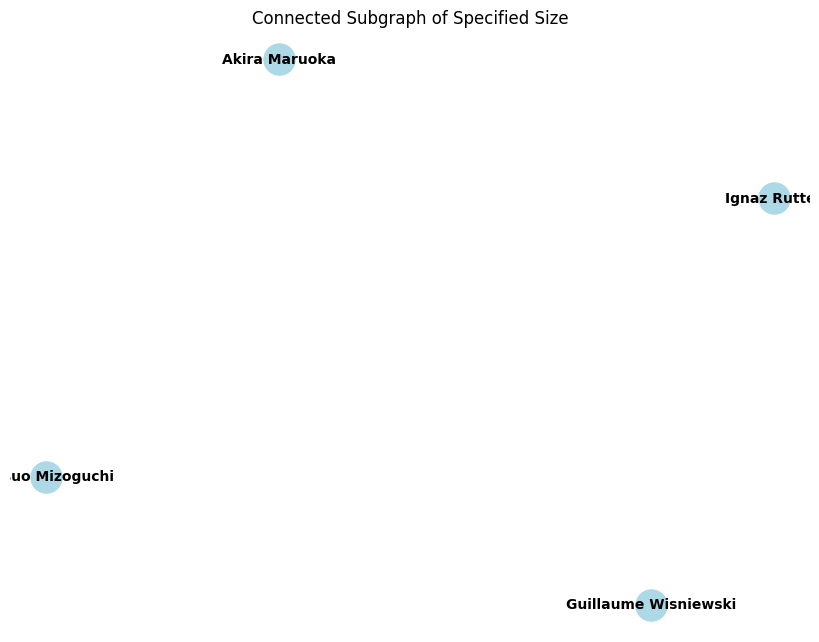

In [6]:
network_main = pickle.load(open(f"./networks/new_subnets/20_nodes.pkl", 'rb')).copy()
print(nx.number_of_isolates(network_main))
influential_nodes = ps.get_top_ranked_node_each_group(network_main)
influence_net = network_main.subgraph(influential_nodes)
influence_score = ps.sum_edge_weights(influence_net)

# Plot the subgraph
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
nx.draw(influence_net, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')
plt.title("Connected Subgraph of Specified Size")
plt.show()

4


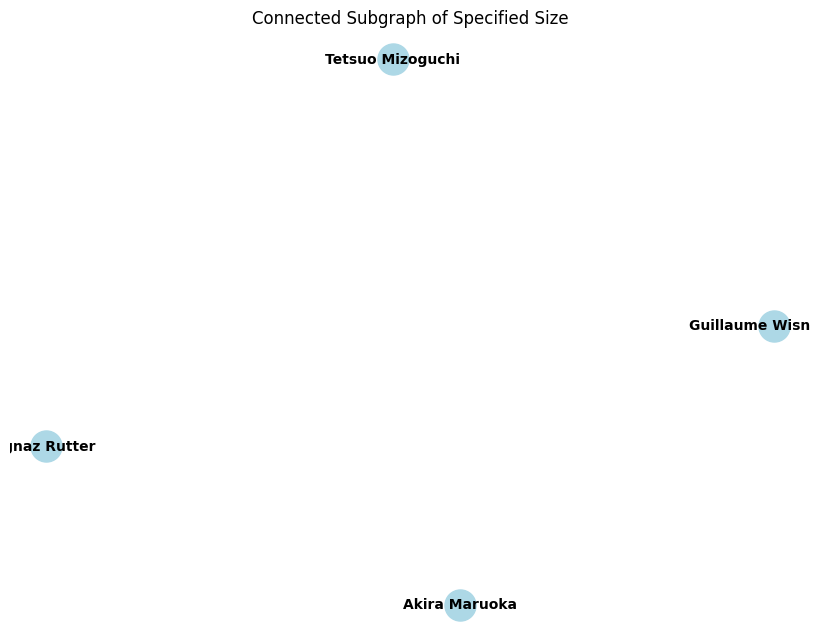

In [9]:
obj_max_2 = 0.0
best_set_2 = set()
projects = [(star_proj, "Star-Structured Project"), (full_proj, "Fully-connected Structured Project"), (chain_proj, "Chain-Structured Project")]

influential_nodes = ps.get_top_ranked_node_each_group(network_main.copy())
for node in influential_nodes:
    subset, comm_eff = ps.Greedy(network_main.copy(), projects[0][0], node, beta=None)
    if comm_eff > obj_max_2:
        obj_max_2 = comm_eff
        best_set_2 = subset

network = network_main.subgraph(list(best_set_2))
print(nx.number_of_isolates(network))

# Plot the subgraph
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
nx.draw(network, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')
plt.title("Connected Subgraph of Specified Size")
plt.show()

Team :DB, Node: Babu Krishnaswamy, Rank: 2
Team :DM, Node: Denny Vrandecic, Rank: 1
Team :AI, Node: Avrim Blum, Rank: 5
Team :T, Node: Yi Wu, Rank: 1
Leaders Score: 2.9
Objective value : 16.3585
Number of Isolated Nodes: 2


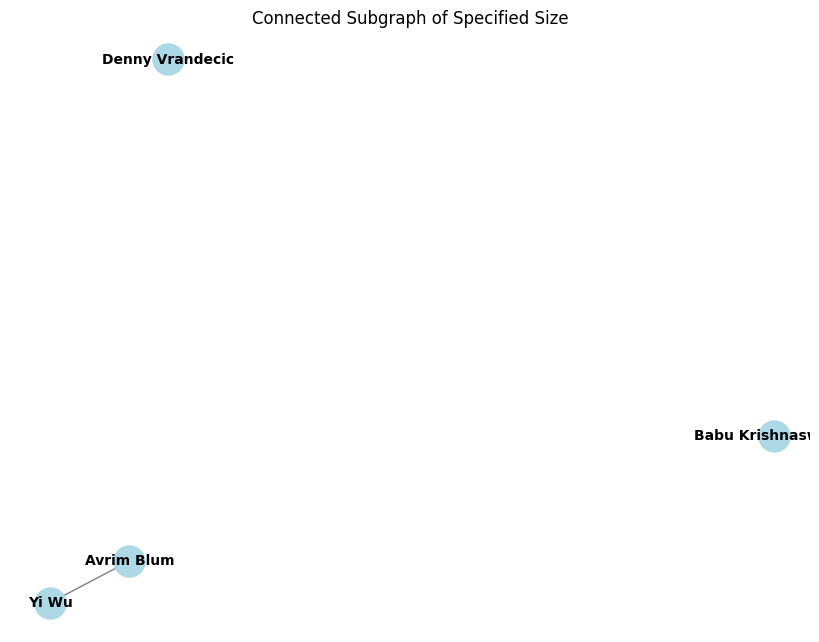

In [44]:
network = pickle.load(open(f"./networks/new_subnets/5_nodes.pkl", 'rb')).copy()
# network.remove_edges_from(nx.selfloop_edges(network))
network = ps.remove_edges_based_on_project_network(network, projects[0][0])
obj_max_1 = 0.0
best_set_1 = set()
for node in network.nodes():
    subset, comm_eff = ps.Greedy(network, projects[0][0], node, beta=0.9)
    if comm_eff > obj_max_1:
        obj_max_1 = comm_eff
        best_set_1 = subset

for node in best_set_1:
    print(f"Team :{network.copy().nodes[node]['label']}, Node: {node}, Rank: {ps.get_node_rank(network.copy(), node)}")

print(f"Leaders Score: {ps.sum_edge_weights(network.copy().subgraph(best_set_1))}")
print(f"Objective value : {obj_max_1}")

network = network.subgraph(list(best_set_1))
print(f"Number of Isolated Nodes: {nx.number_of_isolates(network)}")

# Plot the subgraph
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
nx.draw(network, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')
plt.title("Connected Subgraph of Specified Size")
plt.show()

In [41]:
network.nodes(data=True)

NodeDataView({'Bogdan S. Chlebus': {'label': 'T'}, 'Juha Karhunen': {'label': 'AI'}, 'Mark Sandler': {'label': 'DM'}, 'Jörg Hakenberg': {'label': 'DB'}})

## Using Monte Carlo for Random

In [ ]:
network_main = pickle.load(open("./networks/network.pkl", 'rb'))
nx.number_of_isolates(network_main)

In [ ]:
projects = [(star_proj, "Star-Structured Project"), (full_proj, "Fully-connected Structured Project"), (chain_proj, "Chain-Structured Project")]

for i in range(5, 21, 5):
    network_main = pickle.load(open(f"./networks/new_subnets/{i}_nodes.pkl", 'rb'))
    # network_main = ps.add_weights(network_main.copy())

    for project in projects:
        network = ps.remove_edges_based_on_project_network(network_main.copy(), project[0]).copy()
        average_weight = ps.randomMonteCarlo(network_main, 1000)

        print(f"{i}_node_network: {project[1]} : {average_weight}")

In [ ]:
# 5 nodes

species = ("Star", "Chain", "Full")
penguin_means = {
    'Random': (),
    'Inf-Greedy': (50.209, 50.209, 50.209),
    'Greedy': (80.824, 80.824, 80.824)
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Selected Leaders without considering project structure for 10 node network')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 120)

plt.show()

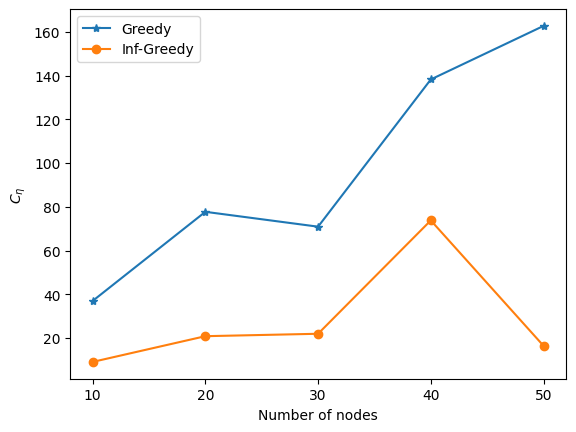

In [45]:
# Star Plot

x = [10, 20, 30, 40, 50]
y_greedy = [36.96, 77.7188, 70.9197, 138.2486, 162.7254]
y_inf_greedy = [9.078, 20.8476, 21.9526, 73.7888, 16.4414]

plt.plot(x, y_greedy, '*-', label='Greedy')
plt.plot(x, y_inf_greedy, 'o-', label='Inf-Greedy')
plt.xlabel('Number of nodes')
plt.ylabel(r"$C_{\eta}$")
plt.xticks(range(10, 51, 10))
# plt.title('Objective Function for Star-Structured Project')
plt.legend()
plt.show()

In [ ]:
# Chain Plot

x = [10, 20, 30, 40, 50]
y_greedy = [36.73, 77.5038, 54.4915, 136.3134, 162.3294]
y_inf_greedy = [8.618, 20.6326, 21.1986, 21.7183, 16.0454]

plt.plot(x, y_greedy, '*-', label='Greedy')
plt.plot(x, y_inf_greedy, 'o-', label='Inf-Greedy')
plt.xlabel('Number of nodes')
plt.ylabel(r"$C_{\eta}$")
plt.xticks(range(10, 51, 10))
# plt.title('Objective Function for Chain-Structured Project')
plt.legend()
plt.show()

In [ ]:
# Fully Plot

x = [10, 20, 30, 40, 50]
y_greedy = [36.96, 77.7188, 70.9197, 138.2486, 162.7254]
y_inf_greedy = [9.078, 20.8476, 21.9526, 73.7888, 16.4414]

plt.plot(x, y_greedy, '*-', label='Greedy')
plt.plot(x, y_inf_greedy, 'o-', label='Inf-Greedy')
plt.xlabel('Number of nodes')
plt.ylabel(r"$C_{\eta}$")
plt.xticks(range(10, 51, 10))
# plt.title('Objective Function for Chain-Structured Project')
plt.legend()
plt.show()